# Apprentissage par renforcement profond

## 1. Import + création des classes nécessaires + Initialisation des variables

In [1]:

import gym

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import copy

from gym.wrappers.record_video import RecordVideo


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
#Création de notre experience replay
class ExperienceReplay:
    
    #Initialise un ER de taille capacity
    def __init__(self,capacity):
        self.capacity = capacity
        self.data = []
    
    #Ajouter les données d'un step à notre ER
    def add_step(self,step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
    
    #Retourne un échantillon de notre ER
    def sample(self, n):
        n = min(n,len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data)[indices]
        
        state_data = torch.tensor(np.stack(samples[:, 0])).float()
        act_data = torch.tensor(np.stack(samples[:, 1])).long()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).float()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

In [4]:

#Création de notre DQN
class DQN(torch.nn.Module):
    
    #Détail de notre DQN
    def __init__(self, input_size, output_size): 
        super(DQN, self).__init__() 

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(64, output_size))

    #Utilisation du DQN
    def forward(self, x): 
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2) 
        x4 = self.layer4(x3)
        return x4
    
    #Entraînement sur un batch de données
    def train_on_batch(self, target_model, optimizer, obs, acts, rewards, next_obs, 
                       terminals, gamma=0.99):
        
        #Calcul des next_act avec le model de base
        next_q_values = self.forward(next_obs)
        max_next_acts = torch.max(next_q_values, dim=1)[1].detach()
        
        #Calcul des q_values avec le target model
        target_next_q_values = target_model.forward(next_obs)
        max_next_q_values = target_next_q_values.gather(index=max_next_acts.view(-1, 1), dim=1)
        max_next_q_values = max_next_q_values.view(-1).detach()        
        
        #Calcul de la "vraie" q value
        terminal_mods = 1 - terminals
        actual_qs = rewards + terminal_mods * gamma * max_next_q_values
            
        pred_qs = self.forward(obs)
        pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)
        
        loss = torch.mean((actual_qs - pred_qs) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [5]:
#Initialisation des différents paramètres
#Pour trouver les bons hyperparamètres, nous avons beaucoup tatônner et expérimenter
#Les paramètres suivants sont ceux qui ont donné les meilleurs résultats
n_episodes = 1500    #nbr épisodes max pour training
max_steps = 500    #nbr step max par épisode
er_capacity = 2000    #capacité de notre ER
input_size = env.observation_space.shape[0]    #taille de l'input de notre réseau
output_size = env.action_space.n    #taille de sortie
update_freq = 1    #fréquence de mise à jour de notre réseau
target_update_delay = 100    #fréquence de mise à jour du target_model
n_anneal_steps = 5000    #paramètre pour contrôler l'exploration
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.25, 1)   #fonction permettant de contrôler lexploration
train_batch_size = 32    #taille d'un batch d'entraînement
learning_rate = 0.00025
print_freq = 20

## 2. Train du modèle

### Entraînement sans enregistrement

In [6]:
#Initialisation de l'environnement
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.action_space.seed(0)

observation, info = env.reset(seed=42)

#Initialisation de l'ER, du model, du target_model
er = ExperienceReplay(er_capacity)
model = DQN(input_size, output_size)
target_model = copy.deepcopy(model)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
all_rewards = []
global_step = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

for episode in range(n_episodes):
    
    #Reset de l'environnement et des variables pour chaque nouvel épisode
    obs, info = env.reset()
    obs = torch.tensor(obs)
    
    episode_reward = 0
    step = 0
    
    while step < max_steps:

        #Début du step
        #Choix d'une action random pour explorer ou non en fonction de la valeur d'epsilon
        if np.random.rand() < epsilon(global_step):
            act = env.action_space.sample()
        else:
            q_values = model(obs)
            q_values = q_values.cpu().detach().numpy()
            act = np.argmax(q_values)
                   
        
        #Récuperation des données suite à l'action faite
        next_obs, reward, terminated, truncated, info = env.step(act)
        next_obs = torch.tensor(next_obs)
        episode_reward += reward
        
        #Ajout des données à l'ER
        er.add_step([obs, act, reward, next_obs, int(terminated)])
        obs = next_obs
        
        #Train sur un batch
        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            model.train_on_batch(target_model, optimizer, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data)
        
        #Mise à jour du target_model
        if global_step and global_step % target_update_delay == 0:
            #print("update target")
            target_model = copy.deepcopy(model)
            

        #Fin du step
        step += 1
        global_step += 1
        
        if terminated:
            break

    all_rewards.append(episode_reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))
    
    #Fin de l'apprentissage si on a une moyenne satisfaisante sur les derniers essais + sauvegarde du modèle
    if np.mean(all_rewards[-print_freq:]) >= 470:
        print(episode)
        save = model.state_dict()
        break
        
env.close()

The model will be running on cpu device


C:\Users\user\AppData\Local\Temp\ipykernel_13888\3554490833.py:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples = np.asarray(self.data)[indices]
C:\Users\user\AppData\Local\Temp\ipykernel_13888\3554490833.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.asarray(self.data)[indices]


Episode #0 | Step #23 | Epsilon 1.00 | Avg. Reward 23.00
Episode #20 | Step #487 | Epsilon 0.91 | Avg. Reward 23.20
Episode #40 | Step #891 | Epsilon 0.84 | Avg. Reward 20.20
Episode #60 | Step #1282 | Epsilon 0.77 | Avg. Reward 19.55
Episode #80 | Step #1654 | Epsilon 0.70 | Avg. Reward 18.60
Episode #100 | Step #1950 | Epsilon 0.65 | Avg. Reward 14.80
Episode #120 | Step #2241 | Epsilon 0.60 | Avg. Reward 14.55
Episode #140 | Step #2559 | Epsilon 0.54 | Avg. Reward 15.90
Episode #160 | Step #2824 | Epsilon 0.49 | Avg. Reward 13.25
Episode #180 | Step #3079 | Epsilon 0.45 | Avg. Reward 12.75
Episode #200 | Step #3706 | Epsilon 0.33 | Avg. Reward 31.35
Episode #220 | Step #4807 | Epsilon 0.25 | Avg. Reward 55.05
Episode #240 | Step #5914 | Epsilon 0.25 | Avg. Reward 55.35
Episode #260 | Step #7377 | Epsilon 0.25 | Avg. Reward 73.15
Episode #280 | Step #9476 | Epsilon 0.25 | Avg. Reward 104.95
Episode #300 | Step #12707 | Epsilon 0.25 | Avg. Reward 161.55
Episode #320 | Step #17984 | Ep

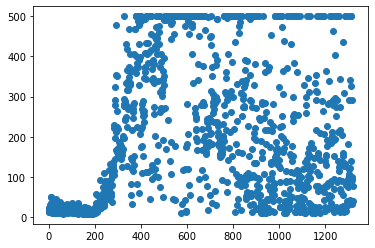

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# création de données
x = list(range(episode))
y = all_rewards
 
plt.scatter(x, y)
plt.xlabel("Épisodes", size = 16,)
plt.ylabel("Reward", size = 16)
plt.title("Reward en fonction du nombre d'épisodes")
plt.show()

### Enregistrement vidéo pendant l'entraînement

In [ ]:
def mod20(x):
    return x%20 == 0

#Initialisation de l'environnement
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.action_space.seed(0)

#Wrappers permettant d'enregistrer certains épisodes (ici tous les 20 épisodes)
wrapped_env = RecordVideo(env, video_folder='video_train', episode_trigger=mod20)
wrapped_env.action_space

observation, info = wrapped_env.reset(seed=42)

#Initialisation de l'ER, du model, du target_model
er = ExperienceReplay(er_capacity)
model = DQN(input_size, output_size)
target_model = copy.deepcopy(model)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
all_rewards = []
global_step = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

for episode in range(n_episodes):
    
    #Reset de l'environnement et des variables pour chaque nouvel épisode
    obs, info = wrapped_env.reset()
    obs = torch.tensor(obs)
    
    episode_reward = 0
    step = 0
    
    while step < max_steps:

        #Début du step
        #Choix d'une action random pour explorer ou non en fonction de la valeur d'epsilon
        if np.random.rand() < epsilon(global_step):
            act = wrapped_env.action_space.sample()
        else:
            q_values = model(obs)
            q_values = q_values.cpu().detach().numpy()
            act = np.argmax(q_values)
                   
        
        #Récuperation des données suite à l'action faite
        next_obs, reward, terminated, truncated, info = wrapped_env.step(act)
        next_obs = torch.tensor(next_obs)
        episode_reward += reward
        
        #Ajout des données à l'ER
        er.add_step([obs, act, reward, next_obs, int(terminated)])
        obs = next_obs
        
        #Train sur un batch
        if global_step % update_freq == 0:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            model.train_on_batch(target_model, optimizer, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data)
        
        #Mise à jour du target_model
        if global_step and global_step % target_update_delay == 0:
            #print("update target")
            target_model = copy.deepcopy(model)
            

        #Fin du step
        step += 1
        global_step += 1
        
        if terminated:
            break

    all_rewards.append(episode_reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))
    
    #Fin de l'apprentissage si on a une moyenne satisfaisante sur les derniers essais + sauvegarde du modèle
    if np.mean(all_rewards[-print_freq:]) == 450:
        print(episode)
        save = model.state_dict()
        break
        
wrapped_env.close()

D:\Anaconda\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The model will be running on cpu device


D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
t:   0%|                                                        

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-0.mp4
Episode #0 | Step #27 | Epsilon 1.00 | Avg. Reward 27.00


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-20.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-20.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-20.mp4


Episode #20 | Step #421 | Epsilon 0.92 | Avg. Reward 19.70


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-40.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-40.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-40.mp4
Episode #40 | Step #842 | Epsilon 0.85 | Avg. Reward 21.05


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-60.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-60.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-60.mp4
Episode #60 | Step #1210 | Epsilon 0.78 | Avg. Reward 18.40


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-80.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-80.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-80.mp4


Episode #80 | Step #1648 | Epsilon 0.70 | Avg. Reward 21.90


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-100.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-100.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-100.mp4
Episode #100 | Step #1986 | Epsilon 0.64 | Avg. Reward 16.90


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-120.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-120.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-120.mp4
Episode #120 | Step #2302 | Epsilon 0.59 | Avg. Reward 15.80


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-140.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-140.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-140.mp4
Episode #140 | Step #2570 | Epsilon 0.54 | Avg. Reward 13.40


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-160.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-160.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-160.mp4


Episode #160 | Step #2837 | Epsilon 0.49 | Avg. Reward 13.35


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-180.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-180.mp4

Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-180.mp4
Episode #180 | Step #3085 | Epsilon 0.44 | Avg. Reward 12.40


t:  19%|█████████████                                                       | 18/94 [00:00<00:00, 178.70it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-200.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-200.mp4
Episode #200 | Step #3454 | Epsilon 0.38 | Avg. Reward 18.45


t:   3%|██▎                                                                   | 2/62 [00:00<00:04, 12.38it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-220.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-220.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-220.mp4
Episode #220 | Step #4455 | Epsilon 0.25 | Avg. Reward 50.05


t:  16%|███████████                                                         | 11/68 [00:00<00:00, 109.20it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-240.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-240.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-240.mp4
Episode #240 | Step #5622 | Epsilon 0.25 | Avg. Reward 58.35


t:   6%|████                                                                  | 2/35 [00:00<00:02, 15.43it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-260.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-260.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-260.mp4
Episode #260 | Step #6737 | Epsilon 0.25 | Avg. Reward 55.75


t:  96%|█████████████████████████████████████████████████████████████████▌  | 55/57 [00:00<00:00, 311.56it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-280.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-280.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-280.mp4
Episode #280 | Step #7957 | Epsilon 0.25 | Avg. Reward 61.00


t:   4%|██▌                                                                   | 2/55 [00:00<00:03, 16.17it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-300.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-300.mp4
Episode #300 | Step #9474 | Epsilon 0.25 | Avg. Reward 75.85


t:  12%|████████                                                           | 13/108 [00:00<00:00, 129.06it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-320.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-320.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-320.mp4
Episode #320 | Step #12301 | Epsilon 0.25 | Avg. Reward 141.35


t:   1%|▌                                                                    | 2/237 [00:00<00:12, 18.15it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-340.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-340.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-340.mp4
Episode #340 | Step #13920 | Epsilon 0.25 | Avg. Reward 80.95


t:   1%|▋                                                                    | 2/188 [00:00<00:09, 18.83it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-360.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-360.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-360.mp4
Episode #360 | Step #16420 | Epsilon 0.25 | Avg. Reward 125.00


Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-380.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-380.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-380.mp4
Episode #380 | Step #19152 | Epsilon 0.25 | Avg. Reward 136.60


t:   1%|▍                                                                    | 2/308 [00:00<00:23, 13.11it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-400.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-400.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-400.mp4
Episode #400 | Step #22932 | Epsilon 0.25 | Avg. Reward 189.00


t:   2%|█▋                                                                   | 4/163 [00:00<00:03, 39.98it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-420.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-420.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\Notebook\video\rl-video-episode-420.mp4
Episode #420 | Step #27445 | Epsilon 0.25 | Avg. Reward 225.65
1000


In [ ]:
x =  list(range(episode+1))
x
plt.plot(x,all_rewards)

## 3. Test du modèle

In [ ]:
#Fonction pour tester un modèle
def test(model):
    
    env = gym.make("CartPole-v1", render_mode="human")
    obs, info = env.reset()
    obs = torch.tensor(obs)
    episode_reward = 0
    terminated = 0
    step = 0
    
    while step < 500:
           
        q_values = model(obs)
        q_values = q_values.cpu().detach().numpy()
        act = np.argmax(q_values)

        next_obs, reward, terminated, truncated, info = env.step(act)
        next_obs = torch.tensor(next_obs)
        episode_reward += reward

        obs = next_obs
        
        if terminated:
            break
        
        step +=1
        
    env.close()
    print(episode_reward)
    
def test_record(model):
    
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    
    #Wrappers permettant d'enregistrer certains épisodes (ici tous les 20 épisodes)
    wrapped_env = RecordVideo(env, video_folder='video_test')
    wrapped_env.action_space
    
    obs, info = wrapped_env.reset()
    obs = torch.tensor(obs)
    episode_reward = 0
    terminated = 0
    step = 0
    
    while step < 500:
           
        q_values = model(obs)
        q_values = q_values.cpu().detach().numpy()
        act = np.argmax(q_values)

        next_obs, reward, terminated, truncated, info = wrapped_env.step(act)
        next_obs = torch.tensor(next_obs)
        episode_reward += reward

        obs = next_obs
        
        if terminated:
            break
        
        step +=1
        
    wrapped_env.close()
    print(episode_reward)

In [ ]:
90%30

0

In [ ]:
# commandes pour charger un modèle

perfect = DQN(input_size,output_size)
perfect.load_state_dict(torch.load('score500'))
perfect

DQN(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
test(perfect)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1000.0


In [ ]:
test_record(perfect)

t:   4%|██▋                                                                | 20/501 [00:00<00:02, 196.60it/s, now=None]

Moviepy - Building video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\apprentissage-par-renforcement-profond\video_test\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\apprentissage-par-renforcement-profond\video_test\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\flori\Desktop\ECL\Cours-TD\4A\MasterIA\projet2\apprentissage-par-renforcement-profond\video_test\rl-video-episode-0.mp4
20000.0


In [ ]:
env.close()

In [ ]:
# commandes pour enregistrer un modèle

#mod = model.state_dict()
#torch.save(mod, 'score500')